In [1]:
# prerequisites
# https://github.com/lyeoni/pytorch-mnist-GAN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.nn.functional import pdist

import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
bs = 100
n_samples = 1000 # set at 1000, a potential breakpoint for mode collapse
tr_split_len = n_samples
te_split_len = n_samples

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

part_tr = torch.utils.data.random_split(train_dataset, [tr_split_len, len(train_dataset)-tr_split_len])[0]
part_te = torch.utils.data.random_split(test_dataset, [te_split_len, len(test_dataset)-te_split_len])[0]

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=part_tr, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=part_te, batch_size=bs, shuffle=False)

In [3]:
print(type(train_dataset))
print(train_dataset)

print(type(train_loader))
print(train_loader)

print(len(train_loader.dataset))

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
<class 'torch.utils.data.dataloader.DataLoader'>
1000


# Normal Referee GAN

In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [5]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

C:\Users\Alex\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
G

In [ ]:
D

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 2
print_stride = 20

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), f'./samples/sample_{n_samples}' + '.png')

## Normal GAN - Inserting lipschitz into it at problem areas

In [14]:
def lip_pen_batch(enc, dec):
    # given a n-batch of encoded points and their decoded representation
    # compute the mean pairwise distance in encoded space over decoded space
    # pairwise distances given by upper triangle (non diagonal) of proximity matrix
    
    numer = torch.mean(pdist(enc, p=2))
    
    denom = torch.mean(pdist(dec, p=2))
    
    new_pen = numer/denom
    
    return new_pen, numer, denom

In [15]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [16]:
def G_train(x, penalty = 'none', alpha = 0):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)
    
    if penalty == 'batch_lipschitz':
        pen, numer, denom = lip_pen_batch(z, G_output)
        G_loss = G_loss + alpha*pen

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [27]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss and penalty
criterion = nn.BCELoss()
alpha = .1

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

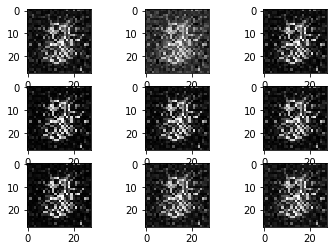

[20/1000]: loss_d: 1.465, loss_g: 1.122


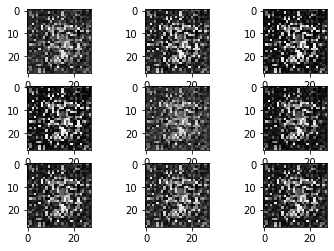

[40/1000]: loss_d: 0.641, loss_g: 2.194


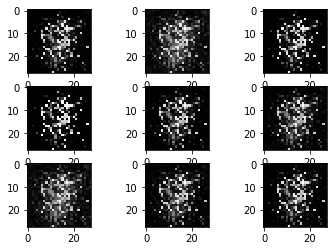

[60/1000]: loss_d: 0.937, loss_g: 4.883


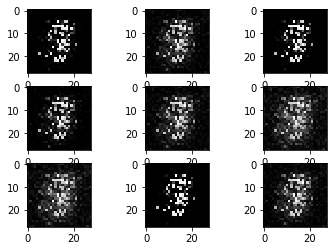

[80/1000]: loss_d: 0.245, loss_g: 6.009


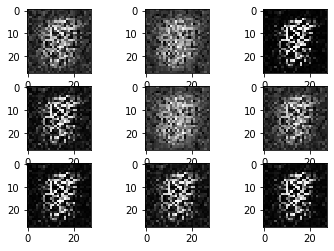

[100/1000]: loss_d: 0.706, loss_g: 3.420


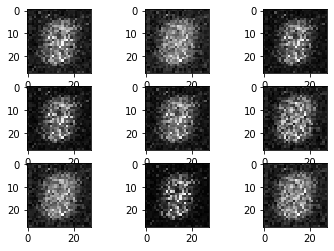

[120/1000]: loss_d: 0.985, loss_g: 2.441


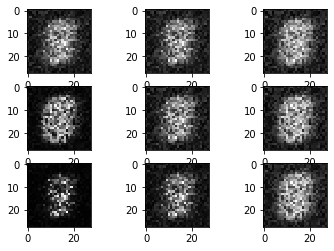

[140/1000]: loss_d: 0.870, loss_g: 2.264


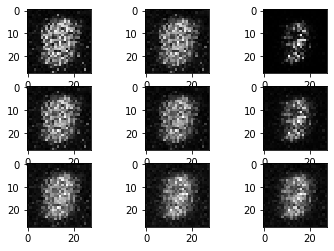

[160/1000]: loss_d: 0.757, loss_g: 3.512


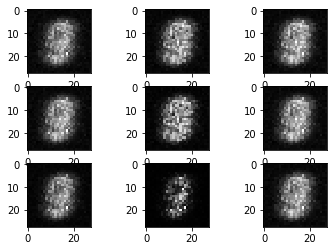

[180/1000]: loss_d: 1.252, loss_g: 1.763


In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 1000
print_stride = 20

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x, penalty = 'batch_lipschitz', alpha = alpha))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

## Relative Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class RelDiscriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(RelDiscriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return self.fc4(x) # needs linear output

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
RD = RelDiscriminator(mnist_dim).to(device)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
RD_optimizer = optim.Adam(RD.parameters(), lr = lr)

In [ ]:
G

In [ ]:
RD

In [ ]:
# TAKEN FROM ANOTEHR

def RD_train(x_r):
    RD.zero_grad()
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))

    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)

    sout = torch.sigmoid(RD(x_r) - RD(x_f))# where C is some discrim with LINEAR OUTPUT
    RD_loss = -torch.mean(torch.log(sout))
    
    RD_loss.backward() #retain_graph=True
    RD_optimizer.step()
        
    return  RD_loss.data.item()

# For paper recreation
def RD_G_train(x_r):
    G.zero_grad()
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))


    # My code
    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)
    
    sout = torch.sigmoid(RD(x_f) - RD(x_r))

    G_loss = -torch.mean(torch.log(sout))
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 200
print_stride = 20

for epoch in range(1, n_epoch+1):           
    RD_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        RD_losses.append(RD_train(x))
        G_losses.append(RD_G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(RD_losses)), torch.mean(torch.FloatTensor(G_losses))))

## Referee (and split referee) Discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Referee(nn.Module):
    def __init__(self, r_input_dim):
        super(Referee, self).__init__()
        self.fc1 = nn.Linear(r_input_dim, 2048)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, left, right):
        x = torch.cat((left, right), 1)
        
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [ ]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
R = Referee(mnist_dim*2).to(device)

In [ ]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
R_optimizer = optim.Adam(R.parameters(), lr = lr)

In [ ]:
G

In [ ]:
R

In [ ]:
# TAKEN FROM ANOTEHR

def R_train(x):
    R.zero_grad()
    
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_f, y_f = G(z), Variable(torch.ones(bs, 1).to(device))

    # train referee on real in 0th index
    x_r, y_r = x.view(-1, mnist_dim), torch.zeros(bs, 1)
    x_r, y_r = Variable(x_r.to(device)), Variable(y_r.to(device))

    R_output = R(x_r, x_f)
    R_real_loss = criterion(R_output, y_r)
    #R_real_score = D_output
    

    # train referee on real in 1th index
    R_output = R(x_f, x_r)
    R_fake_loss = criterion(R_output, y_f)
    #D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    R_loss = R_real_loss + R_fake_loss
    R_loss.backward()
    R_optimizer.step()
        
    return  R_loss.data.item()

# For paper recreation
def R_G_train(x_r):
    G.zero_grad()
    
    x_r = Variable(x_r.view(-1, mnist_dim).to(device))
    latent_samples = Variable(torch.randn(bs, z_dim)).to(device)
    x_f = G(latent_samples)
    ones = Variable(torch.ones(bs, 1).to(device))
    
    R_output = R(x_r, x_f) #ref wants this to be 0, g wants this to be 1

    G_loss = criterion(R_output, ones) # G loss low when R_output near 1
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
#n_epoch = 1*(60000//n_samples) #200 by 60000 is default
n_epoch = 200
print_stride = 1

for epoch in range(1, n_epoch+1):           
    R_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        R_losses.append(R_train(x))
        G_losses.append(R_G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(R_losses)), torch.mean(torch.FloatTensor(G_losses))))